In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
# Getting the Arabic stopwords from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('arabic'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Specify the path to your dataset directory
dataset_dir = "/content/drive/MyDrive/traffic_analysis/AFND/Dataset"

In [ ]:
# Read sources.json
sources_file_path = '/content/drive/MyDrive/traffic_analysis/AFND/sources.json'
with open(sources_file_path, 'r', encoding='utf-8') as sources_file:
    sources_data = json.load(sources_file)
sources_df = pd.DataFrame(list(sources_data.items()), columns=['source', 'label'])

In [ ]:
# Read scraped_articles.json for each source
articles_data = []

for source in sources_df['source']:
    scraped_articles_path = os.path.join(dataset_dir, source, 'scraped_articles.json')

    # Check if the file exists before attempting to read it
    if os.path.exists(scraped_articles_path):
        with open(scraped_articles_path, 'r', encoding='utf-8') as articles_file:
            source_articles_dict = json.load(articles_file)
            source_articles_list = source_articles_dict.get("articles", [])

            # Add a 'source' key to each article
            for article in source_articles_list:
                article['source'] = source

            articles_data.extend(source_articles_list)

# Convert articles_data to a DataFrame
articles_df = pd.DataFrame(articles_data)

In [ ]:
# Merge the articles with their sources(labels)
merged_df = pd.merge(articles_df, sources_df, how='inner', left_on='source', right_on='source')

In [ ]:
print(merged_df['label'].value_counts())
merged_df.head()

label
undecided       232369
credible        207310
not credible    167233
Name: count, dtype: int64


,title,text,published date,source,label
0,المنتخب الوطني المغربي لأقل من 20 سنة يخوض تجم...,يخوض المنتخب الوطني المغربي لكرة القدم لأقل من...,2021-05-23T00:00:00,source_1,credible
1,وزير النقل اعمارة:السرعة عامل مسبب لحوادث السي...,ترأس عبد القادر اعمارة، وزير التجهيز و النقل و...,2021-05-22T00:00:00,source_1,credible
2,"ميسي يؤكد أن الفوز بكأس اسبانيا كان ""نقطة تحول""",أكد النجم الارجنتيني ليونيل ميسي أن فوز فريقه ...,2021-05-22T00:00:00,source_1,credible
3,دبلوماسي مغربي سابق بإسبانيا لـ2M.ma: خطأ مدري...,أكّد الدبلوماسي المغربي السابق بإسبانيا، عبد ا...,2021-05-22T00:00:00,source_1,credible
4,شركتان، فرنسية وبريطانية تعلنان عن نتائج إيجاب...,أعلنت شركتا سانوفي الفرنسية العملاقة في تصنيع ...,2021-05-17T00:00:00,source_1,credible


In [ ]:
merged_df.shape

(606912, 5)

Text(0, 0.5, '# of Articles')

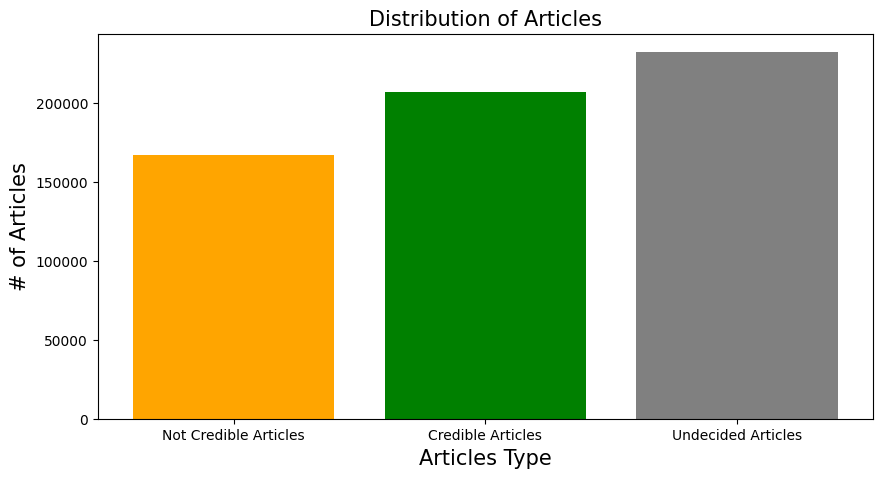

In [ ]:
plt.figure(figsize=(10, 5))
plt.bar('Not Credible Articles', len(merged_df[merged_df['label'] == 'not credible']), color='orange')
plt.bar('Credible Articles', len(merged_df[merged_df['label'] == 'credible']), color='green')
plt.bar('Undecided Articles', len(merged_df[merged_df['label'] == 'undecided']), color='gray')
plt.title('Distribution of Articles', size=15)
plt.xlabel('Articles Type', size=15)
plt.ylabel('# of Articles', size=15)

In [ ]:
# Data Preparation
X = merged_df['text']
y = merged_df['label']

In [ ]:
# Remove Arabic stopwords
X = X.apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))

In [ ]:
# Use LabelEncoder to convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Tokenization and Padding
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:
max_sequence_length = 128   # Set an appropriate value
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

In [ ]:
import pickle

with open('/content/drive/MyDrive/traffic_analysis/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# LSTM Model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100))
model.add(SpatialDropout1D(0.2))  # Dropout layer for regularization
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(units=len(np.unique(y_encoded)), activation='softmax'))

In [ ]:
# Compile the Model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Print the Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         182679900 
                                                                 
 spatial_dropout1d (Spatial  (None, None, 100)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, None, 64)          42240     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 182755359 (697.16 MB)
Trainable params: 182755359 (697.16 MB)
Non-trainable params: 0 (0.00 Byte)
__________

In [ ]:
# Train the Model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train_padded, y_train, epochs=10, validation_split=0.2, batch_size=64, shuffle=True, callbacks=[early_stop])




Epoch 1/10
6070/6070 [==============================] - 445s 72ms/step - loss: 0.8843 - accuracy: 0.5682 - val_loss: 0.7830 - val_accuracy: 0.6397
Epoch 2/10
6070/6070 [==============================] - 343s 57ms/step - loss: 0.7500 - accuracy: 0.6609 - val_loss: 0.7284 - val_accuracy: 0.6646
Epoch 3/10
6070/6070 [==============================] - 345s 57ms/step - loss: 0.6895 - accuracy: 0.6890 - val_loss: 0.6924 - val_accuracy: 0.6853
Epoch 4/10
6070/6070 [==============================] - 346s 57ms/step - loss: 0.6570 - accuracy: 0.7050 - val_loss: 0.6860 - val_accuracy: 0.6896
Epoch 5/10
6070/6070 [==============================] - 345s 57ms/step - loss: 0.6362 - accuracy: 0.7157 - val_loss: 0.6716 - val_accuracy: 0.6958
Epoch 6/10
6070/6070 [==============================] - 340s 56ms/step - loss: 0.6197 - accuracy: 0.7234 - val_loss: 0.6608 - val_accuracy: 0.6976
Epoch 7/10
6070/6070 [==============================] - 339s 56ms/step - loss: 0.6044 - accuracy: 0.7313 - val_loss: 0

In [ ]:
model.save('/content/drive/MyDrive/traffic_analysis/lstm_model3.h5')

from keras.models import load_model

# Assuming 'model' is already defined and trained
tf.keras.models.save_model(model, '/content/drive/MyDrive/traffic_analysis/lstm_model3k.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
<ipython-input-24-bf71622f8033>:6: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, '/content/drive/MyDrive/traffic_analysis/lstm_model3k.h5')


In [ ]:
# Evaluate the Model
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

3794/3794 [==============================] - 38s 10ms/step
Test Accuracy: 0.7012


In [ ]:
# Evaluate other metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73     41308
           1       0.66      0.58      0.62     33392
           2       0.72      0.74      0.73     46683

    accuracy                           0.70    121383
   macro avg       0.70      0.69      0.69    121383
weighted avg       0.70      0.70      0.70    121383



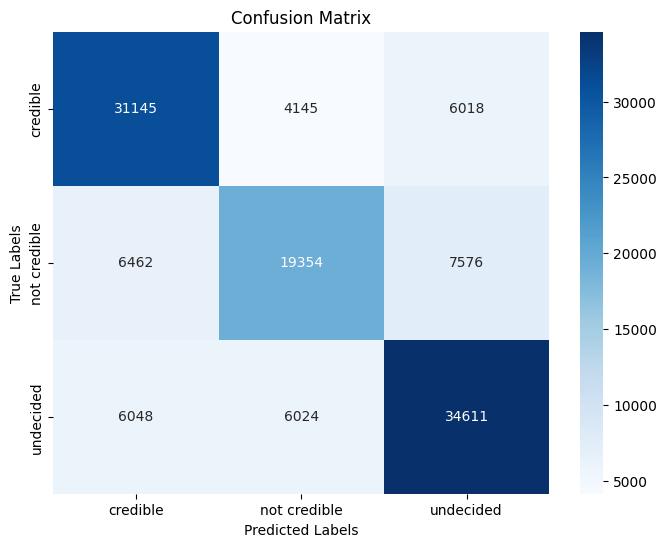

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Load model with custom objects
model = tf.keras.models.load_model("/content/drive/MyDrive/traffic_analysis/lstm_model3k.h5")

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         182679900 
                                                                 
 spatial_dropout1d (Spatial  (None, None, 100)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, None, 64)          42240     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 182755359 (697.16 MB)
Trainable params: 182755359 (697.16 MB)
Non-trainable params: 0 (0.00 Byte)
__________